
# Set up the notebook

In [1]:

%pprint

Pretty printing has been turned OFF


In [2]:

import sys

# Insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../py')

from stats_scraping_utils import StatsScrapingUtilities
from storage import Storage
import matplotlib.pyplot as plt
import os
import textwrap
import seaborn as sns
import numpy as np
import pandas as pd
import re
from scipy import stats
from scipy.stats import pearsonr
%matplotlib inline

# Use the following only if you are on a high definition device
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

s = Storage()
ssu = StatsScrapingUtilities(s=s)


----


# Prepare the Pandemics scatterplot


## Get the Basic Reproduction Number data

In [3]:

url = 'https://en.wikipedia.org/wiki/Basic_reproduction_number'
print(f'The Basic Reproduction Number data is from {url}.')
if s.pickle_exists('R0s_df'):
    R0s_df = s.load_object('R0s_df')
else:
    tables_list = ssu.get_page_tables(url)
    R0s_df = tables_list[0].copy()
    # print(R0s_df.columns.tolist())
    R0s_df.columns = ['disease_name', 'transmitted_by', 'R0', 'HIT']
    for cn in ['R0']:
        R0s_df[cn] = R0s_df[cn].map(lambda x: re.split(r'[^0-9\.]+', str(x).strip(), 0)[0])
        R0s_df[cn] = pd.to_numeric(R0s_df[cn], errors='coerce', downcast='float')
    display(R0s_df.head(7).T)
    s.store_objects(R0s_df=R0s_df)

The Basic Reproduction Number data is from https://en.wikipedia.org/wiki/Basic_reproduction_number.



## Get the Case Fatality Rate data

In [4]:

url = 'https://en.wikipedia.org/wiki/List_of_human_disease_case_fatality_rates'
print(f'The Case Fatality Rate data is from {url}.')
if s.pickle_exists('CFRs_df'):
    CFRs_df = s.load_object('CFRs_df')
else:
    tables_list = ssu.get_page_tables(url)
    CFRs_df = tables_list[0].copy()
    print(CFRs_df.columns.tolist())
    CFRs_df.columns = ['disease_name', 'disease_type', 'treatment_by', 'CFR', 'disease_notes', 'references']
    for cn in ['CFR']:
        CFRs_df[cn] = CFRs_df[cn].map(lambda x: re.sub(r'[^0-9\.–]+', '', str(x)).split('–')[0])
        CFRs_df[cn] = pd.to_numeric(CFRs_df[cn], errors='coerce', downcast='integer')
    display(CFRs_df.head(7).T)
    s.store_objects(CFRs_df=CFRs_df)

The Case Fatality Rate data is from https://en.wikipedia.org/wiki/List_of_human_disease_case_fatality_rates.


In [5]:

# Remove disease misspellings
R0s_df['short_disease_name'] = R0s_df.disease_name.map(lambda x: ssu.disease_name_dict.get(x, x))
CFRs_df['short_disease_name'] = CFRs_df.disease_name.map(lambda x: ssu.disease_name_dict.get(x, x))
diseases_list = sorted(set(R0s_df.short_disease_name).symmetric_difference(set(CFRs_df.short_disease_name)))
if diseases_list:
    print(diseases_list)
doubles_df = ssu.check_4_doubles(diseases_list)
mask_series = (doubles_df.max_similarity > 0.6)
if doubles_df[mask_series].shape[0]:
    columns_list = ['first_item', 'second_item', 'max_similarity']
    display(doubles_df[mask_series][columns_list].sort_values('max_similarity', ascending=False))

['1956 Flu', '1968 Flu', '2009 Flu', '2014 Ebola', 'Alphaherpesvirus', 'Angiostrongyliasis', 'Aspergillosis', 'Baylisascariasis', 'Botulism', 'Brucellosis', 'Bubonic Plague', 'COVID-19 Alpha', 'COVID-19 Delta', 'COVID-19 Omicron', 'Capillariasis', 'Cholera', 'Cutaneous Anthrax', 'DHF', 'Diphtheria', 'EBOV', 'EEE', 'Encephalopathies', 'GAE', 'Glanders', 'H5N1 Flu', 'HFMD', 'HPS', 'Hepatitis A', 'Influenza A', 'Intestinal Anthrax', 'Lassa', 'Legionellosis', 'Leishmaniasis', 'Leptospirosis', 'ME', 'Malaria', 'Marburg', 'Measles', 'Meningitis', 'Meningoencephalitis', 'Monkeypox', 'Mucormycosis', 'Mumps', 'Nipah', 'Oropharyngeal Anthrax', 'Pneumonic Plague', 'Pneumonic Tularemia', 'Pulmonary Anthrax', 'Rabies', 'Respiratory Diphtheria', 'Rhinovirus', 'Rubella', 'Rubeola', 'Septicemic Plague', 'Sleeping Sickness', 'Smallpox', 'Tetanus', 'Tuberculosis', 'Typhoid', 'Typhoidal Tularemia', 'VEE', 'Variola Major', 'Variola Minor', 'Yellow fever']


,first_item,second_item,max_similarity
0,1956 Flu,1968 Flu,0.875000
51,Rubella,Rubeola,0.857143
61,Variola Major,Variola Minor,0.846154
10,Bubonic Plague,Pneumonic Plague,0.800000
11,COVID-19 Alpha,COVID-19 Delta,0.785714
45,Pneumonic Plague,Pneumonic Tularemia,0.742857
6,Aspergillosis,Legionellosis,0.692308
38,Meningitis,Meningoencephalitis,0.689655
20,EEE,VEE,0.666667
44,Oropharyngeal Anthrax,Pulmonary Anthrax,0.631579


In [6]:

# Assume all the variants are the same CFR as the original and add them in
mask_series = (CFRs_df.short_disease_name == 'COVID-19')
c19_df = CFRs_df[mask_series]
c19_df.short_disease_name = 'COVID-19 Alpha'
c19_df.disease_name = 'COVID-19 (Alpha variant)'
CFRs_df = CFRs_df.append(c19_df)
c19_df.short_disease_name = 'COVID-19 Delta'
c19_df.disease_name = 'COVID-19 (Delta variant)'
CFRs_df = CFRs_df.append(c19_df)
c19_df.short_disease_name = 'COVID-19 Omicron'
c19_df.disease_name = 'COVID-19 (Omicron variant)'
CFRs_df = CFRs_df.append(c19_df)
mask_series = (CFRs_df.short_disease_name == 'Seasonal Flu')
flu_df = CFRs_df[mask_series]
flu_df.short_disease_name = '2009 Flu'
flu_df.disease_name = 'Influenza (2009 pandemic strain)'
CFRs_df = CFRs_df.append(flu_df)

In [7]:

# Get every disease duplicated across the two datasets if possble
typos_df = ssu.check_for_typos(R0s_df.short_disease_name.unique(), CFRs_df.short_disease_name.unique(),
                               verbose=False).rename(columns={'left_item': 'R0', 'right_item': 'CFR'})
mask_series = (typos_df.max_similarity < 1.0)
df = typos_df[mask_series].sort_values(['max_similarity', 'R0', 'CFR'], ascending=[False, True, True])
f_str = "There are a large number of Basic Reproduction Number (R0s) I don't have Case Fatality Rates (CFRs) for: "
print(f_str + ssu.conjunctify_nouns(df.R0.tolist()) + '.')
df

There are a large number of Basic Reproduction Number (R0s) I don't have Case Fatality Rates (CFRs) for: Rubella, Diphtheria, Rhinovirus, Measles, 2014 Ebola, Mumps, Smallpox, Monkeypox, and Nipah.


,R0,CFR,max_similarity
4,Rubella,Rubeola,0.857143
13,Diphtheria,Respiratory Diphtheria,0.625000
14,Rhinovirus,Hantavirus,0.600000
0,Measles,Lassa,0.500000
17,2014 Ebola,Rubeola,0.470588
2,Mumps,Mucormycosis,0.470588
8,Smallpox,Seasonal Flu,0.400000
15,Monkeypox,Mucormycosis,0.380952
21,Nipah,Malaria,0.333333


In [8]:

# Assume all the strains are the same R0 as the original and add them in
mask_series = (R0s_df.short_disease_name == 'Seasonal Flu')
flu_df = R0s_df[mask_series]
flu_df.short_disease_name = '1968 Flu'
flu_df.disease_name = 'Hong Kong (1968–69) flu'
R0s_df = R0s_df.append(flu_df)
flu_df.short_disease_name = '1956 Flu'
flu_df.disease_name = 'Asian (1956–58) flu'
R0s_df = R0s_df.append(flu_df)
flu_df.short_disease_name = 'H5N1 Flu'
flu_df.disease_name = 'Influenza A virus subtype H5N1'
R0s_df = R0s_df.append(flu_df)

In [9]:

# Get every disease duplicated across the two datasets if possble
typos_df = ssu.check_for_typos(CFRs_df.short_disease_name.unique(), R0s_df.short_disease_name.unique(),
                               verbose=False).rename(columns={'left_item': 'CFR', 'right_item': 'R0'})
mask_series = (typos_df.max_similarity < 1.0)
df = typos_df[mask_series].sort_values(['max_similarity', 'CFR', 'R0'], ascending=[False, True, True])
f_str = "There are a large number of Case Fatality Rates (CFRs) I don't have Basic Reproduction Number (R0s) for: "
print(f_str + ssu.conjunctify_nouns(df.CFR.tolist()) + '.')
df

There are a large number of Case Fatality Rates (CFRs) I don't have Basic Reproduction Number (R0s) for: Rubeola, ME, Respiratory Diphtheria, Tuberculosis, Leptospirosis, Variola Major, Variola Minor, Brucellosis, Lassa, Malaria, Tetanus, Hepatitis A, Botulism, Cholera, Mucormycosis, Alphaherpesvirus, Rabies, Aspergillosis, Capillariasis, Leishmaniasis, Glanders, Encephalopathies, Pneumonic Plague, Meningitis, Intestinal Anthrax, Legionellosis, Oropharyngeal Anthrax, Bubonic Plague, Septicemic Plague, Typhoid, DHF, Angiostrongyliasis, Marburg, Meningoencephalitis, Typhoidal Tularemia, EBOV, HFMD, HPS, VEE, Cutaneous Anthrax, Pneumonic Tularemia, Baylisascariasis, Yellow fever, Pulmonary Anthrax, Sleeping Sickness, EEE, GAE, and Influenza A.


,CFR,R0,max_similarity
45,Rubeola,Rubella,0.857143
50,ME,MERS,0.666667
39,Respiratory Diphtheria,Diphtheria,0.625000
21,Tuberculosis,Pertussis,0.571429
33,Leptospirosis,Pertussis,0.545455
8,Variola Major,Varicella,0.545455
51,Variola Minor,Varicella,0.545455
46,Brucellosis,Varicella,0.500000
49,Lassa,Measles,0.500000
55,Malaria,Varicella,0.500000



# Create the Pandemics scatterplot

In [10]:

kwargs = dict(textcoords='offset points', ha='left', va='bottom',
              bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
red_kwargs = dict(textcoords='offset points', ha='left', va='bottom',
                  bbox=dict(boxstyle='round,pad=0.5', fc='pink', alpha=0.5),
                  arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

ev_column_name = 'R0'
rv_column_name = 'CFR'

column_description_dict = s.load_object('column_description_dict')
explanatory_variable = column_description_dict.get(ev_column_name, ev_column_name)
response_variable = column_description_dict.get(rv_column_name, rv_column_name)

svg_dir = os.path.join(s.saves_folder, 'svg')
os.makedirs(name=svg_dir, exist_ok=True)

In [11]:

merged_df = R0s_df.merge(CFRs_df, on='short_disease_name', suffixes=['_R0', '_CFR']).set_index('short_disease_name', drop=True)
df = merged_df.reset_index(drop=False).set_index('disease_name_CFR', drop=True)
columns_list = [ev_column_name, rv_column_name]
df = df[columns_list].dropna()
ev_max = df[ev_column_name].max()
ev_min = df[ev_column_name].min()
rv_min = df[rv_column_name].min()
rv_max = df[rv_column_name].max()

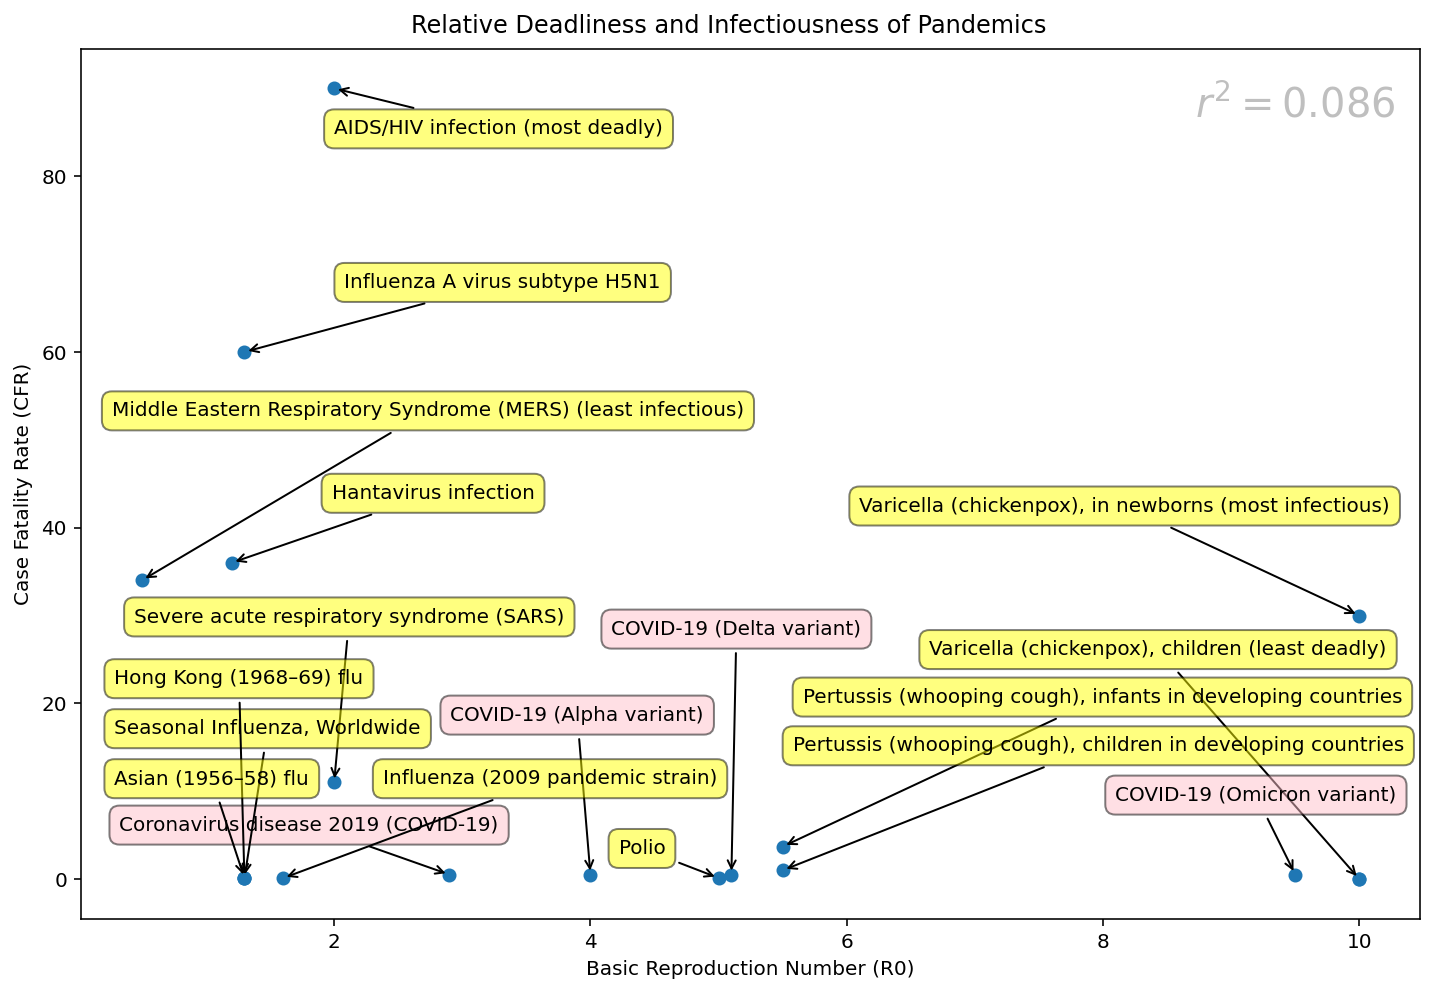

In [12]:

# First order (linear) scatterplot
fig1_fig = plt.figure(figsize=(12,8))
merge_axes_subplot = plt.scatter(x=df[ev_column_name].tolist(), y=df[rv_column_name].tolist(), s=None, c=None, marker=None, cmap=None,
                                 norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, edgecolors=None,
                                 plotnonfinite=False, data=df)
xlabel_text = plt.xlabel('Basic Reproduction Number ({})'.format(explanatory_variable))
ylabel_text = plt.ylabel('Case Fatality Rate ({})'.format(response_variable))

# Add annotations
ev_min_labeled = False
ev_min_str = 'least infectious'
ev_min_xytext = (-15, 80)
ev_max_labeled = False
ev_max_str = 'most infectious'
ev_max_xytext = (-250, 50)
rv_min_labeled = False
rv_min_str = 'least deadly'
rv_min_xytext = (-215, 110)
rv_max_labeled = False
rv_max_str = 'most deadly'
rv_max_xytext = (0, -25)
for label, x, y in zip(df.index, df[ev_column_name], df[rv_column_name]):
    if (y == rv_min):
        if not rv_min_labeled:
            rv_min_labeled = True
            annotation = plt.annotate('{} ({})'.format(label, rv_min_str), xy=(x, y), xytext=rv_min_xytext, **kwargs)
    elif (y == rv_max):
        if not rv_max_labeled:
            rv_max_labeled = True
            annotation = plt.annotate('{} ({})'.format(label, rv_max_str), xy=(x, y), xytext=rv_max_xytext, **kwargs)
    elif (x == ev_min):
        if not ev_min_labeled:
            ev_min_labeled = True
            annotation = plt.annotate('{} ({})'.format(label, ev_min_str), xy=(x, y), xytext=ev_min_xytext, **kwargs)
    elif (x == ev_max):
        if not ev_max_labeled:
            ev_max_labeled = True
            annotation = plt.annotate('{} ({})'.format(label, ev_max_str), xy=(x, y), xytext=ev_max_xytext, **kwargs)
    elif ('-19' in label) and ('alpha' in label.lower()):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-70, 75), **red_kwargs)
    elif ('-19' in label) and ('coronavirus' in label.lower()):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-165, 20), **red_kwargs)
    elif ('-19' in label) and ('delta' in label.lower()):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-60, 118), **red_kwargs)
    elif ('-19' in label) and ('omicron' in label.lower()):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-90, 35), **red_kwargs)
    elif ('-19' in label):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-75, 35), **red_kwargs)
    elif ('sars' in label.lower()):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-100, 78), **kwargs)
    elif ('kong' in label.lower()):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-65, 95), **kwargs)
    elif ('swine' in label.lower()):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-50, 100-2.7842095), **kwargs)
    elif ('seasonal' in label.lower()):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-65, 70), **kwargs)
    elif ('spanish' in label.lower()):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-59, 128), **kwargs)
    elif ('asian' in label.lower()):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-65, 45), **kwargs)
    elif ('whooping' in label.lower()) and ('infants' in label.lower()):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(10, 70), **kwargs)
    elif ('whooping' in label.lower()) and ('children' in label.lower()):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(5, 57.5), **kwargs)
    elif ('polio' in label.lower()):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-50, 10), **kwargs)
    elif ('2009' in label):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(50, 45), **kwargs)
    else:
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(50, 30), **kwargs)

# Add r-squared
x = df[ev_column_name].values
y = df[rv_column_name].values
plt.text(9.5, 88, r'$r^2 = {0:.2}$'.format(stats.pearsonr(x, y)[0] ** 2), fontsize=20, alpha=0.25,
         horizontalalignment='center', verticalalignment='center')
plt.suptitle(t='Relative Deadliness and Infectiousness of Pandemics', x=0.5, y=0.91)
left, right = plt.xlim()
bottom, top = plt.ylim()
file_path = os.path.join(svg_dir, 'pandemic.svg')
plt.savefig(file_path)
with open(file_path, 'r') as f:
    xml_str = f.read()
    d_regex = re.compile('d="([^"\r\n]+)[\r\n]+')
    while d_regex.search(xml_str):
        xml_str = d_regex.sub(r'd="\g<1>', xml_str)
    with open(file_path, 'w') as f:
        print(xml_str.strip(), file=f)